In [6]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt

def rotation_matrix(axis: npt.ArrayLike, angle: float) -> npt.NDArray:
	# normalize axis vector
	axis = axis / np.linalg.norm(axis)
	x, y, z = axis
	c = np.cos(angle)
	s = np.sin(angle)
	t = 1 - c
	
	rot_mat = np.array([
		[t*x*x + c, t*x*y - z*s, t*x*z + y*s],
		[t*x*y + z*s, t*y*y + c, t*y*z - x*s],
		[t*x*z - y*s, t*y*z + x*s, t*z*z + c]
	])
	return rot_mat

def tip_matrix(alpha: float, phi: float) -> npt.NDArray:
	axis = np.array([np.cos(phi), np.sin(phi), 0])
	angle = alpha
	return rotation_matrix(axis, angle)

def relaxation_terms(t1: float, t2: float, t: float) -> tuple[npt.ArrayLike, npt.ArrayLike]:
	e1 = np.exp(-t / t1)
	e2 = np.exp(-t / t2)

	return np.array([e2, e2, e1]), np.array([0, 0, 1 - e1])

def off_res_rotation_matrix(off_res: float, t: float) -> npt.NDArray:
	axis = np.array([0, 0, 1])
	angle = 2.0 * np.pi * off_res * t
	return rotation_matrix(axis, angle)

In [7]:
def bssfp_sample_transient(tr_max: int, tr: float, te: float, t1: float, t2: float, alpha: float, phi: float, off_res: float) -> npt.ArrayLike:
	m = np.array([0, 0, 1])

	samples = []

	tip = tip_matrix(alpha, phi)
	relax_te_1, relax_te_2 = relaxation_terms(t1, t2, te)
	relax_tr_1, relax_tr_2 = relaxation_terms(t1, t2, tr)
	off_res_rot_te = off_res_rotation_matrix(off_res, te)
	off_res_rot_tr = off_res_rotation_matrix(off_res, tr)

	for _ in range(tr_max):
		m = tip @ m
		m_after_te = off_res_rot_te @ (relax_te_1 * m + relax_te_2)
		m_xy_sampled = np.linalg.norm(m_after_te[:2])
		samples.append(m_xy_sampled)
		m = off_res_rot_tr @ (relax_tr_1 * m + relax_tr_2)
	
	return samples

def bssfp_steady_state_transient(tr_max: int, tr: float, te: float, t1: float, t2: float, alpha: float, phi: float, off_res: float) -> npt.ArrayLike:
	m = np.array([0, 0, 1])

	tip = tip_matrix(alpha, phi)
	relax_1, relax_2 = relaxation_terms(t1, t2, tr)
	off_res_rot = off_res_rotation_matrix(off_res, tr)

	for _ in range(tr_max):
		m = tip @ m
		m = relax_1 * m + relax_2
		m = off_res_rot @ m
	
	return np.linalg.norm(m[:2])

In [ ]:
# Common parameters

tr_max = 1000
tr = 10 / 1000
te = 5 / 1000
t1 = 1000 / 1000
t2 = 100 / 1000

alpha = np.deg2rad(30)
phi = 0

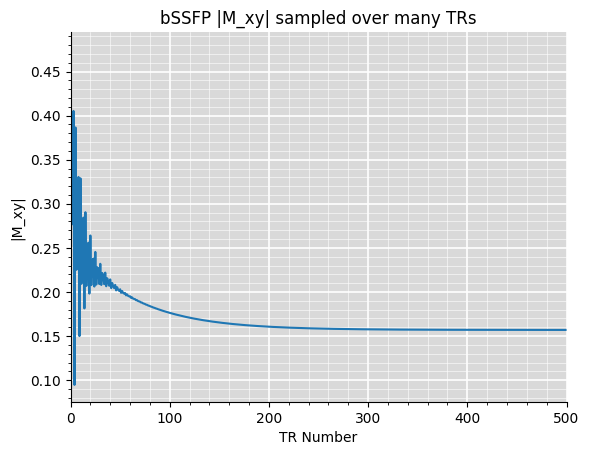

In [16]:
off_res = 40

samples = bssfp_sample_transient(tr_max, tr, te, t1, t2, alpha, phi, off_res)

fig, ax = plt.subplots()

ax.plot(samples)

ax.set_title("bSSFP |M_xy| sampled over many TRs")
ax.set_xlabel("TR Number")
ax.set_xlim(0, tr_max)
ax.set_ylabel("|M_xy|")

ax.set_facecolor("0.85")
ax.spines[["right", "top"]].set_visible(False)
ax.minorticks_on()
ax.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)

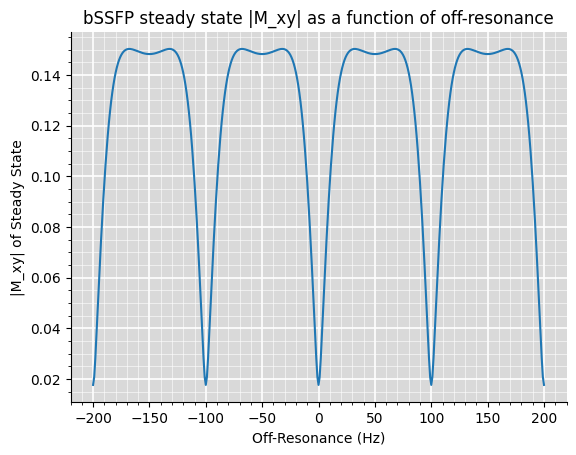

In [18]:
off_res_vec = np.linspace(-200, 200, 401)
steady_states = []

for off_res in off_res_vec:
	steady_states.append(bssfp_steady_state_transient(tr_max, tr, te, t1, t2, alpha, phi, off_res))

fig, ax = plt.subplots()

ax.plot(off_res_vec, steady_states)

ax.set_title("bSSFP steady state |M_xy| as a function of off-resonance")
ax.set_xlabel("Off-Resonance (Hz)")
ax.set_ylabel("|M_xy| of Steady State")

ax.set_facecolor("0.85")
ax.spines[["right", "top"]].set_visible(False)
ax.minorticks_on()
ax.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)